# Full Transfer Functions

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs

# np.set_printoptions(threshold=np.nan)

In [3]:
# mDM = 1e11
# sigmav = 1e-24

# def rate_func_swave(rs):
#     return 0*phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

# def test(rs, x1, x2, x3):
#     return 0.3

# test = tla.get_history(
#                 np.array([phys.TCMB(3000), 1, 0, 0]), 0.3, 0.3, 0.3, 
#                 rate_func_swave, np.flipud(np.arange(1, 3001)), reion_switch=False
#             )

# out = np.stack((np.flipud(np.arange(1, 3001)), test[:,0], test[:,1]))
# # pickle.dump(
# #     out, open("/Users/hongwan/GitHub/DarkHistory/darkhistory/history/std_soln.p", "wb")       
# #            )

In [4]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

In [5]:
rs = 600
print(xe_std(rs))
print(T_m_std(rs)/phys.kB)
print(phys.TCMB(rs)/phys.kB)

0.0009648017275850074
1625.561215315584
1635.2995445551107


In [6]:
# plt.figure()

# plt.plot(np.flipud(np.arange(1, 3001)), test[:,0]/phys.kB)
# plt.plot(np.flipud(np.arange(1, 3001)), phys.TCMB(np.flipud(np.arange(1, 3001)))/phys.kB, 'k:')
# ax = plt.gca()

# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.figure()

# plt.plot(np.flipud(np.arange(1, 3001)), test[:,1])
# ax = plt.gca()

# ax.set_xscale('log')
# ax.set_yscale('log')

## Photon Transfer Functions

In [7]:
user = 'hongwan'

highengphot_tflist_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_complete_coarse.raw", "rb"))
lowengphot_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_complete_coarse.raw", "rb"))
lowengelec_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_complete_coarse.raw", "rb"))
CMB_engloss_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_complete_coarse.raw", "rb"))

In [8]:
highengphot_tflist_arr[0]._grid_vals.shape

(51, 325, 500)

In [9]:
photeng = highengphot_tflist_arr[0].eng
eleceng = lowengelec_tflist_arr[0].eng

#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3000]
eleceng_low  = eleceng[eleceng <= 3000]


for highengphot_tflist in highengphot_tflist_arr:
    
#     highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

    for tf in highengphot_tflist:
        # tf.rebin(photeng_high)
#         tf.rebin(photeng)
        
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (0, 0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    highengphot_tflist._eng = photeng
    highengphot_tflist._in_eng = photeng
    highengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in highengphot_tflist._tflist])
    )
    
# lowengphot_tflist.in_eng set to photeng_high
for lowengphot_tflist in lowengphot_tflist_arr:
    
#     lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengphot_tflist:
#         tf.rebin(photeng)
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        # Photons in the low energy bins should be immediately deposited.
        tf._grid_vals[0:photeng_low.size, 0:photeng_low.size] = np.identity(photeng_low.size)
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    lowengphot_tflist._eng = photeng
    lowengphot_tflist._in_eng = photeng
    lowengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengphot_tflist._tflist])
    )
    
# lowengelec_tflist.in_eng set to photeng_high 
for lowengelec_tflist in lowengelec_tflist_arr:
    
#     lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengelec_tflist:
#         tf.rebin(eleceng)
        # Pad with zeros so that it becomes photeng x eleceng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = eleceng
        tf._rs = tf.rs[0]*np.ones_like(photeng)

    lowengelec_tflist._eng = eleceng
    lowengelec_tflist._in_eng = photeng
    lowengelec_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengelec_tflist._tflist])
    )
    
    for engloss in CMB_engloss_arr:
        engloss = np.pad(engloss, ((0,0),(photeng_low.size, 0)), 'constant')


In [10]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])


In [11]:
highengphot_tf_interp = tflist.TransferFuncInterp(xes, highengphot_tflist_arr)
lowengphot_tf_interp = tflist.TransferFuncInterp(xes, lowengphot_tflist_arr)
lowengelec_tf_interp = tflist.TransferFuncInterp(xes, lowengelec_tflist_arr)


phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([1e11]), 
                                      photeng)
phot_spec_init.switch_spec_type()


In [28]:
phot_spec_init.rs = 1800
end_rs   = 18
mDM = 1e8
sigmav = 1e-26
tau = 1e26

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)


def evolve(
    in_spec_elec, in_spec_phot, 
    rate_func_N, rate_func_eng, xe_init, T_m_init,
    highengphot_tf_interp, lowengphot_tf_interp, 
    lowengelec_tf_interp, 
    end_rs, coarsen_factor=1, std_soln=False
):
    """
    Main function that computes the temperature and ionization history. 
    
    Parameters
    ----------
    in_spec_elec : Spectrum
        Spectrum per annihilation/decay into electrons. 
    in_spec_phot : Spectrum
        Spectrum per annihilation/decay into photons.
    rate_func_N : function
        Function describing the rate of annihilation/decay, dN/(dV dt)
    rate_func_eng : function
        Function describing the rate of annihilation/decay, dE/(dV dt)
    xe_init : float
        xe at the initial redshift. 
    T_m_init : float
        Matter temperature at the initial redshift. 
    highengphot_tf_interp : TransferFuncInterp
        Interpolation table for high energy photons. 
    lowengphot_tf_interp : TransferFuncInterp
        Interpolation table for low energy photons. 
    lowengelec_tf_interp : TransferFuncInterp
        Interpolation table for low energy electrons. 
    end_rs : float
        Final redshift to evolve to. 
    coarsen_factor : int
        Coarsening to apply to the transfer function matrix. 
    std_soln : bool
        If true, uses the standard TLA solution for f(z). 
    """
    
    # Initialize the next spectrum as None.
    next_highengphot_spec = None
    next_lowengphot_spec  = None
    next_lowengelec_spec  = None
    
    if (
        highengphot_tf_interp.dlnz    != lowengphot_tf_interp.dlnz
        or highengphot_tf_interp.dlnz != lowengelec_tf_interp.dlnz
        or lowengphot_tf_interp.dlnz  != lowengelec_tf_interp.dlnz
    ):
        raise TypeError('TransferFuncInterp objects must all have the same dlnz.')
    
    if in_spec_elec.rs != in_spec_phot.rs:
        raise TypeError('Input spectra must have the same rs.')
    
    # redshift/timestep related quantities. 
    dlnz = highengphot_tf_interp.dlnz
    prev_rs = None
    rs = in_spec_phot.rs
    dt = dlnz/phys.hubble(rs)
    
    # The initial input dN/dE per annihilation to per baryon per dlnz, 
    # based on the specified rate. 
    # dN/(dN_B d lnz dE) = dN/dE * (dN_ann/(dV dt)) * dV/dN_B * dt/dlogz
    
    # ICS for in_spec_elec goes here.
    
    init_inj_spec = (
        in_spec_phot * rate_func_N(rs) * dlnz
        / phys.hubble(rs) / (phys.nB * rs**3)
    )
    
    
    # Initialize the Spectra object that will contain all the 
    # output spectra during the evolution.
    out_highengphot_specs = Spectra([init_inj_spec], spec_type=init_inj_spec.spec_type)
    out_lowengphot_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    out_lowengelec_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    
    # Initialize the xe and T array that will store the solutions.
    xe_arr  = np.array([xe_init])
    T_m_arr = np.array([T_m_init])
    
    # Load the standard TLA solution if necessary. 
    if std_soln:
        soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
        xe_std  = interp1d(soln[0,:], soln[2,:])
        T_m_std = interp1d(soln[0,:], soln[1,:])

    # Define these methods for speed.
    append_highengphot_spec = out_highengphot_specs.append
    append_lowengphot_spec  = out_lowengphot_specs.append
    append_lowengelec_spec  = out_lowengelec_specs.append
    
    # Loop while we are still at a redshift above end_rs.
    while rs > end_rs:
        
        # If prev_rs exists, calculate xe and T_m. 
        if prev_rs is not None:
#             print('here at least?')
            
            # f_continuum, f_lyman, f_ionH, f_ionHe, f_heat
            # f_raw takes in dE/(dV dt)
            if std_soln:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([xe_std(rs), 0, 0]), rate_func_eng(rs), dt
                )
            else:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([xe_arr[-1], 0, 0]), rate_func_eng(rs), dt
                )
            
            print('f_cont, f_lyman, f_ionH, f_ionHe, f_heat: ', f_raw)
            
            
            init_cond = np.array([T_m_arr[-1], xe_arr[-1], 0, 0])
#             print(init_cond)
            
            new_vals = tla.get_history(
                init_cond, f_raw[2], f_raw[1], f_raw[4], 
                rate_func_eng, np.array([prev_rs, rs])
            )

            T_m_arr = np.append(T_m_arr, new_vals[-1,0])
            xe_arr  = np.append(xe_arr,  new_vals[-1,1])
            
        print('T_m at '+str(rs)+': '+ str(T_m_arr[-1]))
        print('x_e at '+str(rs)+': '+ str(xe_arr[-1]))
        if std_soln:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_std(rs))
        else:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_arr[-1])
        
#         if coarsen_factor > 1:
#             prop_tf = np.zeros_like(highengphot_tf._grid_vals)
#             for i in np.arange(coarsen_factor):
#                 prop_tf += matrix_power(highengphot_tf._grid_vals, i)
#             lowengphot_tf._grid_vals = np.matmul(prop_tf, lowengphot_tf._grid_vals)
#             lowengelec_tf._grid_vals = np.matmul(prof_tf, lowengelec_tf._grid_vals)
#             highengphot_tf._grid_vals = matrix_power(
#                 highengphot_tf._grid_vals, coarsen_factor
#             )
            
        next_highengphot_spec = highengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengphot_spec  = lowengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengelec_spec  = lowengelec_tf.sum_specs(out_highengphot_specs[-1])
        
        # Re-define existing variables.
        prev_rs = rs
        rs = np.exp(np.log(rs) - 0.002)
        
        dt = dlnz/phys.hubble(rs)
        next_highengphot_spec.rs = rs
        next_lowengphot_spec.rs  = rs
        next_lowengelec_spec.rs  = rs
        
        # Add the next injection spectrum to next_highengphot_spec
        next_inj_spec = (
            in_spec_phot * rate_func_N(rs) 
            / phys.hubble(rs) / (phys.nB * rs**3)
        )
        # This keeps the redshift. 
        next_highengphot_spec.N += next_inj_spec.N
        
        append_highengphot_spec(next_highengphot_spec)
        append_lowengphot_spec(next_lowengphot_spec)
        append_lowengelec_spec(next_lowengelec_spec)
        
        
    return (
        xe_arr, T_m_arr, 
        out_highengphot_specs, out_lowengphot_specs, out_lowengelec_specs
    )
        
        
            
        
            
    


In [34]:
# a = evolve(
#         phot_spec_init*0, phot_spec_init, 
#         rate_func_decay_N, rate_func_decay_eng, .9999, phys.TCMB(phot_spec_init.rs),
#         highengphot_tf_interp, lowengphot_tf_interp, 
#         lowengelec_tf_interp, 
#         end_rs, coarsen_factor=1, std_soln=False
#     )

b = evolve(
        phot_spec_init*0, phot_spec_init, 
        rate_func_decay_N, rate_func_decay_eng, .9999, phys.TCMB(phot_spec_init.rs),
        highengphot_tf_interp, lowengphot_tf_interp, 
        lowengelec_tf_interp, 
        end_rs, coarsen_factor=1, std_soln=True
    )

T_m at 1800: 0.42275759247
x_e at 1800: 0.9999


../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.29134657e-06 1.64419620e-06 2.86034388e-06 4.14421090e-08
 1.44434635e-06]
T_m at 1796.4035976012003: 0.4219125780788214
x_e at 1796.4035976012003: 0.9998223089548006
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.14995821e-03 8.23461939e-04 1.43752981e-03 2.10007183e-05
 7.32799875e-04]
T_m at 1792.814380819186: 0.4210695937751632
x_e at 1792.814380819186: 0.9997556050147419
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.08312086e-03 2.30698762e-03 3.98779188e-03 6.32723600e-05
 2.05199564e-03]
T_m at 1789.2323352970852: 0.420228293954688
x_e at 1789.2323352970852: 0.9996969228718506
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00439407 0.00344104 0.00588714 0.00010014 0.00305665]
T_m at 1785.6574467067112: 0.4193886752140557
x_e at 1785.6574467067112: 0.9996440518858276
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00527984 0.00427244 0.00725746 0.00012915 0.00381495]
T_m at 1782.0897007485048: 0.418550734139281
x_e at 1782.0897007485048: 

T_m at 1641.7892691811799: 0.3855989964302457
x_e at 1641.7892691811799: 0.9962434045810582
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00719345 0.00568414 0.01081036 0.00021245 0.00984553]
T_m at 1638.5089720333979: 0.38482856787106984
x_e at 1638.5089720333979: 0.9960784631736624
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00719326 0.0056615  0.01078597 0.00021444 0.00997035]
T_m at 1635.2352289236887: 0.38405967864346297
x_e at 1635.2352289236887: 0.9959074331452745
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00719302 0.00563878 0.01076151 0.00021646 0.0100951 ]
T_m at 1631.9680267570757: 0.3832923256724168
x_e at 1631.9680267570757: 0.9957301425179643
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00719272 0.00561597 0.01073695 0.00021851 0.01021985]
T_m at 1628.7073524647456: 0.3825265058887334
x_e at 1628.7073524647456: 0.9955464164234198
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00719237 0.00559311 0.01071233 0.00022058 0.01034448]
T_m at 1625.453193003997: 0.3817622162

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00697925 0.00436445 0.00963032 0.00019194 0.01601986]
T_m at 1503.48638054032: 0.3531164433181622
x_e at 1503.48638054032: 0.9804440809976702
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00697136 0.00432142 0.00960537 0.00018859 0.01618643]
T_m at 1500.482412748354: 0.352410916233652
x_e at 1500.482412748354: 0.9797953013016978
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00696478 0.00427947 0.00956848 0.00018953 0.01635779]
T_m at 1497.4844468880399: 0.3517067988486852
x_e at 1497.4844468880399: 0.9791285062302977
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00695825 0.00423784 0.00953167 0.00019137 0.01652729]
T_m at 1494.49247096751: 0.3510040883485949
x_e at 1494.49247096751: 0.9784432581915153
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00695179 0.00419658 0.009495   0.00019354 0.01669538]
T_m at 1491.5064730188565: 0.35030278192441383
x_e at 1491.5064730188565: 0.9777391079399518
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0069

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00670091 0.00273715 0.00808635 0.00012845 0.02274708]
T_m at 1376.8340059851962: 0.3233703147529328
x_e at 1376.8340059851962: 0.927010164921336
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00669374 0.00270169 0.0080525  0.00012604 0.02287876]
T_m at 1374.0830898063768: 0.3227242261841118
x_e at 1374.0830898063768: 0.924940582777366
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00668663 0.00266678 0.00801896 0.00012366 0.02300836]
T_m at 1371.337669961749: 0.32207942876141915
x_e at 1371.337669961749: 0.9228167108761545
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00667958 0.00263242 0.00798573 0.00012133 0.02313573]
T_m at 1368.5977354696295: 0.3214359199143708
x_e at 1368.5977354696295: 0.9206371612143471
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00667259 0.00259863 0.00795281 0.00011904 0.02326086]
T_m at 1365.8632753702764: 0.3207936970779055
x_e at 1365.8632753702764: 0.9184005148904333
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  

T_m at 1268.4385614937335: 0.29791256427159135
x_e at 1268.4385614937335: 0.780275468768258
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.47560319e-03 1.67937992e-03 6.90133409e-03 6.36442432e-05
 2.68659722e-02]
T_m at 1265.904219557463: 0.29731736153636
x_e at 1265.904219557463: 0.774614698904298
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.47024215e-03 1.66165720e-03 6.87090538e-03 6.30005404e-05
 2.69085971e-02]
T_m at 1263.3749412397588: 0.2967233488358218
x_e at 1263.3749412397588: 0.768832899158018
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.46465440e-03 1.64427914e-03 6.84091849e-03 6.23596253e-05
 2.69473092e-02]
T_m at 1260.850716423504: 0.2961305238019256
x_e at 1260.850716423504: 0.7629293125153562
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.45883061e-03 1.62722831e-03 6.81133466e-03 6.17214427e-05
 2.69821960e-02]
T_m at 1258.3315350117962: 0.2955388840700419
x_e at 1258.3315350117962: 0.7569033280234587
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.45277114e-03 1.610

T_m at 1170.9163705020255: 0.2750095250117997
x_e at 1170.9163705020255: 0.4711744265096066
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04874387e-03 1.09692541e-03 5.79595395e-03 3.83011168e-05
 2.64003067e-02]
T_m at 1168.5768780333212: 0.27446010086174566
x_e at 1168.5768780333212: 0.4622400922749966
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.03974740e-03 1.08836752e-03 5.77744320e-03 3.73482784e-05
 2.63502601e-02]
T_m at 1166.2420598736871: 0.2739117738226033
x_e at 1166.2420598736871: 0.45332652200850165
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.03076034e-03 1.08016121e-03 5.75921425e-03 3.64432052e-05
 2.62987934e-02]
T_m at 1163.9119066838475: 0.2733645416231036
x_e at 1163.9119066838475: 0.4444404759531222
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.02179391e-03 1.07228896e-03 5.74126553e-03 3.55794214e-05
 2.62460388e-02]
T_m at 1161.5864091431865: 0.27281840199612317
x_e at 1161.5864091431865: 0.435588628739059
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.01286020

T_m at 1076.5771093130318: 0.2528528737388343
x_e at 1076.5771093130318: 0.16900374434286292
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.79452011e-03 8.98439221e-04 5.27085692e-03 3.68618080e-07
 2.44873036e-02]
T_m at 1074.4261068139058: 0.25234763681734956
x_e at 1074.4261068139058: 0.16432661061940368
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.79382385e-03 8.96289333e-04 5.26640140e-03 3.35583350e-07
 2.44665451e-02]
T_m at 1072.2794020206397: 0.25184340629213303
x_e at 1072.2794020206397: 0.15976544729602266
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.79341030e-03 8.94292507e-04 5.26226034e-03 3.10751641e-07
 2.44472151e-02]
T_m at 1070.1369863464113: 0.2513401800918868
x_e at 1070.1369863464113: 0.1553184911794524
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.79327110e-03 8.92438852e-04 5.25842791e-03 2.91347674e-07
 2.44293162e-02]
T_m at 1067.9988512215552: 0.25083795614733756
x_e at 1067.9988512215552: 0.15098391837746583
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.793

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.99248264e-03 8.82430576e-04 5.31161156e-03 9.87452998e-08
 2.49496747e-02]
T_m at 993.8059277525404: 0.23340798679629482
x_e at 993.8059277525404: 0.05320733002274913
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.00245137e-03 8.83232039e-04 5.31738577e-03 9.65836868e-08
 2.49865646e-02]
T_m at 991.8203021844787: 0.23294139403765995
x_e at 991.8203021844787: 0.05168007901843724
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.01249825e-03 8.84064557e-04 5.32329274e-03 9.45435674e-08
 2.50240347e-02]
T_m at 989.8386438989482: 0.23247572584317464
x_e at 989.8386438989482: 0.05019727380516581
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.02181921e-03 8.82701225e-04 5.32021273e-03 9.79752981e-08
 2.50742209e-02]
T_m at 987.8609449693131: 0.23201097714807017
x_e at 987.8609449693131: 0.04875766937714321
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.03151504e-03 8.82234359e-04 5.32138170e-03 1.02483858e-07
 2.51196764e-02]
T_m at 985.887197484775: 0.

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.47572341e-03 9.29968217e-04 5.63065981e-03 1.57581391e-06
 2.69843578e-02]
T_m at 910.0885876915132: 0.2137232482619234
x_e at 910.0885876915132: 0.015238301514864938
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.48845906e-03 9.31527009e-04 5.64062790e-03 1.79582760e-06
 2.70470901e-02]
T_m at 908.2702294804608: 0.21329525424445833
x_e at 908.2702294804608: 0.014831035044551966
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.50316525e-03 9.33340514e-04 5.65214976e-03 2.05288016e-06
 2.71183888e-02]
T_m at 906.4555043515373: 0.21286808800771032
x_e at 906.4555043515373: 0.01443598854932443
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.51871961e-03 9.35256678e-04 5.66416025e-03 2.35206401e-06
 2.71906561e-02]
T_m at 904.6444050458399: 0.21244174736294522
x_e at 904.6444050458399: 0.014052800736692073
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.53433172e-03 9.37176139e-04 5.67619676e-03 2.69958460e-06
 2.72633511e-02]
T_m at 902.8369243189688:

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.08052940e-03 1.00267124e-03 6.09994453e-03 1.58716668e-10
 2.99042175e-02]
T_m at 841.7995686179073: 0.19762563020645163
x_e at 841.7995686179073: 0.005809890526680628
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.09596849e-03 1.00458350e-03 6.11197261e-03 1.13539150e-10
 2.99794362e-02]
T_m at 840.1176519579705: 0.19722839928366084
x_e at 840.1176519579705: 0.0056856258946269
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.11139155e-03 1.00649387e-03 6.12398897e-03 8.20672004e-11
 3.00546069e-02]
T_m at 838.4390957697616: 0.19683191292672195
x_e at 838.4390957697616: 0.005565022007939957
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.12679858e-03 1.00840238e-03 6.13599370e-03 5.98782157e-11
 3.01297295e-02]
T_m at 836.7638933390538: 0.19643618409856395
x_e at 836.7638933390538: 0.005447964333742672
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.14218922e-03 1.01030894e-03 6.14798613e-03 4.40999242e-11
 3.02047983e-02]
T_m at 835.0920379650349:

T_m at 780.1934828697798: 0.18304755155374863
x_e at 780.1934828697798: 0.0029053134074319975
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.72146623e-03 1.08171891e-03 6.59309997e-03 6.05718631e-14
 3.29591323e-02]
T_m at 778.6346552512681: 0.18267793929171444
x_e at 778.6346552512681: 0.0028626185439723506
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.74102092e-03 1.08409654e-03 6.60777007e-03 5.43013417e-14
 3.30485740e-02]
T_m at 777.0789421724155: 0.18230903015090652
x_e at 777.0789421724155: 0.0028210036056797727
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.76055050e-03 1.08647015e-03 6.62241734e-03 4.88264113e-14
 3.31379495e-02]
T_m at 775.5263374103678: 0.18194082297224207
x_e at 775.5263374103678: 0.0027804351190207632
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.78005466e-03 1.08883974e-03 6.63704138e-03 4.40145081e-14
 3.32272480e-02]
T_m at 773.9768347547038: 0.1815733165960818
x_e at 773.9768347547038: 0.0027408807281792402
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.7

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.53852205e-03 1.18027249e-03 7.20154368e-03 3.18324229e-15
 3.67057465e-02]
T_m at 714.4706678866614: 0.16743413735558701
x_e at 714.4706678866614: 0.0017236337431546511
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.55693378e-03 1.18247428e-03 7.21513915e-03 3.05695475e-15
 3.67902079e-02]
T_m at 713.0431545400726: 0.16709433666357967
x_e at 713.0431545400726: 0.001707619954798567
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.57531852e-03 1.18467200e-03 7.22870947e-03 2.93823637e-15
 3.68745440e-02]
T_m at 711.6184933670526: 0.16675518585442897
x_e at 711.6184933670526: 0.00169190633560945
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.59367629e-03 1.18686564e-03 7.24225470e-03 2.82619624e-15
 3.69587554e-02]
T_m at 710.196678668955: 0.16641668366514978
x_e at 710.196678668955: 0.001676485146543727
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.61200710e-03 1.18905522e-03 7.25577485e-03 2.72053507e-15
 3.70428416e-02]
T_m at 708.7777047585189:

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.48622445e-03 1.29110592e-03 7.88629629e-03 9.68695660e-16
 4.10427145e-02]
T_m at 655.5941632288151: 0.15339390592111532
x_e at 655.5941632288151: 0.0012337687702442812
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.50932763e-03 1.29376353e-03 7.90272047e-03 9.51066246e-16
 4.11481809e-02]
T_m at 654.2842852169954: 0.15308090563796334
x_e at 654.2842852169954: 0.0012258477424684222
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.53239932e-03 1.29641614e-03 7.91911369e-03 9.34014512e-16
 4.12534903e-02]
T_m at 652.977024343189: 0.15276850086247717
x_e at 652.977024343189: 0.0012180372112070015
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.55543951e-03 1.29906376e-03 7.93547598e-03 9.17550009e-16
 4.13586426e-02]
T_m at 651.6723753783505: 0.152456690349233
x_e at 651.6723753783505: 0.0012103349433648103
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.57844823e-03 1.30170641e-03 7.95180742e-03 9.01610397e-16
 4.14636381e-02]
T_m at 650.370333103882

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.05044740e-02 1.40665838e-03 8.60002678e-03 5.39905142e-16
 4.56686236e-02]
T_m at 601.5694222003684: 0.1404574912051105
x_e at 601.5694222003684: 0.0009711043452406143
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.05335580e-02 1.40986539e-03 8.61979129e-03 5.34906667e-16
 4.57985242e-02]
T_m at 600.3674856931206: 0.14016899623699364
x_e at 600.3674856931206: 0.0009664586979796219
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.05626153e-02 1.41306652e-03 8.63952479e-03 5.30019695e-16
 4.59284005e-02]
T_m at 599.167950656616: 0.13988104496096773
x_e at 599.167950656616: 0.0009618635648097063
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.05916427e-02 1.41626175e-03 8.65922579e-03 5.25241573e-16
 4.60582120e-02]
T_m at 597.9708122927128: 0.13959363621681795
x_e at 597.9708122927128: 0.0009573181368481842
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.06206382e-02 1.41945107e-03 8.67889318e-03 5.20573900e-16
 4.61879277e-02]
T_m at 596.77606581285

T_m at 551.9966314895028: 0.12852913734171778
x_e at 551.9966314895028: 0.0008087168623435725
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.17515283e-02 1.54226619e-03 9.43625724e-03 3.93594070e-16
 5.12308347e-02]
T_m at 550.8937414841591: 0.12826300263994153
x_e at 550.8937414841591: 0.0008056790191802166
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.17790687e-02 1.54522039e-03 9.45446700e-03 3.91460635e-16
 5.13530441e-02]
T_m at 549.7930550545161: 0.12799736385814275
x_e at 549.7930550545161: 0.0008026681347942377
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.18065733e-02 1.54816905e-03 9.47264224e-03 3.89362208e-16
 5.14750649e-02]
T_m at 548.6945677978263: 0.1277322199359489
x_e at 548.6945677978263: 0.000799683856308131
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.18340421e-02 1.55111220e-03 9.49078301e-03 3.87298028e-16
 5.15968973e-02]
T_m at 547.5982753201392: 0.12746756981527968
x_e at 547.5982753201392: 0.0007967258369599439
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.18

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.30894179e-02 1.68183756e-03 1.02945538e-02 3.34421416e-16
 5.70646700e-02]
T_m at 507.52295625067586: 0.11776657679926694
x_e at 507.52295625067586: 0.0007008772866009538
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.31246118e-02 1.68542506e-03 1.03165858e-02 3.33458620e-16
 5.72162217e-02]
T_m at 506.50892470772806: 0.11752038554422559
x_e at 506.50892470772806: 0.0006987259047697147
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.31597658e-02 1.68900598e-03 1.03385765e-02 3.32508928e-16
 5.73675465e-02]
T_m at 505.4969192011544: 0.11727464767051708
x_e at 505.4969192011544: 0.0006965907287294626
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.31948801e-02 1.69258032e-03 1.03605260e-02 3.31572109e-16
 5.75186443e-02]
T_m at 504.4869356829316: 0.1170293622134618
x_e at 504.4869356829316: 0.0006944715791309397
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.32299544e-02 1.69614809e-03 1.03824342e-02 3.30647938e-16
 5.76695151e-02]
T_m at 503.47897

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.46437010e-02 1.83776455e-03 1.12511938e-02 3.02871253e-16
 6.36989272e-02]
T_m at 464.7696673733374: 0.10735059274889479
x_e at 464.7696673733374: 0.0006194841953154895
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.46884988e-02 1.84209848e-03 1.12776238e-02 3.02525061e-16
 6.38830310e-02]
T_m at 463.8410569585425: 0.10712346856713509
x_e at 463.8410569585425: 0.0006179056003768335
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.47333444e-02 1.84642619e-03 1.13040271e-02 3.02186557e-16
 6.40674507e-02]
T_m at 462.91430190859376: 0.10689675760282587
x_e at 462.91430190859376: 0.0006163372999731798
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.47782049e-02 1.85074703e-03 1.13303979e-02 3.01854899e-16
 6.42520500e-02]
T_m at 461.9893985164699: 0.10667045897976692
x_e at 461.9893985164699: 0.0006147791962257121
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.48230593e-02 1.85506063e-03 1.13567317e-02 3.01529840e-16
 6.44367218e-02]
T_m at 461.066343

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.64541898e-02 2.00936238e-03 1.22985970e-02 2.92226299e-16
 7.11141247e-02]
T_m at 428.1792618036889: 0.09836827910279605
x_e at 428.1792618036889: 0.0005622723602490276
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.64974281e-02 2.01339172e-03 1.23231652e-02 2.92032937e-16
 7.12895401e-02]
T_m at 427.3237590679849: 0.09815740708829503
x_e at 427.3237590679849: 0.0005610470660283862
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.65406206e-02 2.01741379e-03 1.23476876e-02 2.91842005e-16
 7.14646864e-02]
T_m at 426.4699656278869: 0.09794691449830634
x_e at 426.4699656278869: 0.0005598288941532359
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.65837674e-02 2.02142860e-03 1.23721642e-02 2.91653467e-16
 7.16395636e-02]
T_m at 425.6178780682201: 0.09773680055712117
x_e at 425.6178780682201: 0.0005586177848205254
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.66268684e-02 2.02543616e-03 1.23965952e-02 2.91467290e-16
 7.18141718e-02]
T_m at 424.76749298

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.87037804e-02 2.21201754e-03 1.35282061e-02 2.90091350e-16
 7.99404500e-02]
T_m at 391.3263802488088: 0.08924406469150264
x_e at 391.3263802488088: 0.0005134284688893542
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.87598264e-02 2.21690091e-03 1.35577265e-02 2.90162125e-16
 8.01542924e-02]
T_m at 390.54450961956405: 0.08904953544613026
x_e at 390.54450961956405: 0.0005124729532114958
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.88158241e-02 2.22177575e-03 1.35871929e-02 2.90233136e-16
 8.03678217e-02]
T_m at 389.7642011688785: 0.08885535302873775
x_e at 389.7642011688785: 0.0005115224281291297
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.88717733e-02 2.22664207e-03 1.36166053e-02 2.90304376e-16
 8.05810374e-02]
T_m at 388.9854517755173: 0.08866151675909166
x_e at 388.9854517755173: 0.000510576856655065
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.89276738e-02 2.23149989e-03 1.36459638e-02 2.90376601e-16
 8.07939393e-02]
T_m at 388.2082583

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.09064858e-02 2.40081771e-03 1.46676796e-02 2.93182359e-16
 8.82494268e-02]
T_m at 361.2397783799909: 0.08172690689063102
x_e at 361.2397783799909: 0.0004787661710792257
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.09604883e-02 2.40536926e-03 1.46951029e-02 2.93265168e-16
 8.84507366e-02]
T_m at 360.51802082137544: 0.08154574235569013
x_e at 360.51802082137544: 0.00047798471292131994
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.10159047e-02 2.41004578e-03 1.47233503e-02 2.93377145e-16
 8.86600963e-02]
T_m at 359.797705335324: 0.08136489924532324
x_e at 359.797705335324: 0.0004772070161960795
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.10790119e-02 2.41538588e-03 1.47557254e-02 2.93609639e-16
 8.89041321e-02]
T_m at 359.07882904057357: 0.08118437728841399
x_e at 359.07882904057357: 0.00047643306048655854
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.11498572e-02 2.42129213e-03 1.47908666e-02 2.93861693e-16
 8.91552232e-02]
T_m at 358.3613

T_m at 331.4715367287286: 0.0742202661999975
x_e at 331.4715367287286: 0.0004482828907044212
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.40313356e-02 2.65134855e-03 1.61579125e-02 3.04373977e-16
 9.91823045e-02]
T_m at 330.80925615660357: 0.0740524235548642
x_e at 330.80925615660357: 0.0004476433728958784
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.41023814e-02 2.65690426e-03 1.61908590e-02 3.04624916e-16
 9.94261283e-02]
T_m at 330.14829882194414: 0.07388487886184371
x_e at 330.14829882194414: 0.0004470067239599196
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.41733705e-02 2.66245051e-03 1.62237459e-02 3.04875404e-16
 9.96695873e-02]
T_m at 329.4886620809203: 0.07371763161404495
x_e at 329.4886620809203: 0.0004463729267124017
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.42443026e-02 2.66798733e-03 1.62565731e-02 3.05124934e-16
 9.99126814e-02]
T_m at 328.830343294984: 0.07355068130661725
x_e at 328.830343294984: 0.0004457419641146765
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.73964579e-02 2.90573263e-03 1.76666795e-02 3.18613279e-16
 1.10535597e-01]
T_m at 304.15636991596267: 0.06726620760822737
x_e at 304.15636991596267: 0.00042318107826533335
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.74905373e-02 2.91255677e-03 1.77071554e-02 3.19076918e-16
 1.10846414e-01]
T_m at 303.5486650835315: 0.06711075819150089
x_e at 303.5486650835315: 0.0004226512994856546
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.75845640e-02 2.91936988e-03 1.77475606e-02 3.19538773e-16
 1.11156806e-01]
T_m at 302.9421744461654: 0.06695558738293937
x_e at 302.9421744461654: 0.00042212378060613176
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.76785373e-02 2.92617197e-03 1.77878950e-02 3.19999627e-16
 1.11466768e-01]
T_m at 302.33689557790103: 0.06680069474972593
x_e at 302.33689557790103: 0.0004215985095942232
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.77724567e-02 2.93296305e-03 1.78281586e-02 3.20458816e-16
 1.11776295e-01]
T_m at 301.73

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.11141774e-02 3.17021123e-03 1.92312362e-02 3.36075956e-16
 1.22625141e-01]
T_m at 280.771716927048: 0.0612614598682136
x_e at 280.771716927048: 0.0004036419794748447
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.12058214e-02 3.17660340e-03 1.92689439e-02 3.36485690e-16
 1.22918313e-01]
T_m at 280.21073466245264: 0.06111683743714873
x_e at 280.21073466245264: 0.00040319408340705465
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.12973972e-02 3.18298503e-03 1.93065844e-02 3.36894268e-16
 1.23211043e-01]
T_m at 279.6508732411695: 0.06097247785647932
x_e at 279.6508732411695: 0.00040274803278139704
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.13889044e-02 3.18935611e-03 1.93441578e-02 3.37301401e-16
 1.23503331e-01]
T_m at 279.0921304237523: 0.06082838076902934
x_e at 279.0921304237523: 0.0004023038187968009
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.14803427e-02 3.19571667e-03 1.93816642e-02 3.37707644e-16
 1.23795179e-01]
T_m at 278.5345039

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.57702932e-02 3.47947107e-03 2.10274466e-02 3.57876783e-16
 1.36400032e-01]
T_m at 259.18496149840155: 0.05567869093072557
x_e at 259.18496149840155: 0.0003870941892302193
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.58933597e-02 3.48739735e-03 2.10732132e-02 3.58437901e-16
 1.36752565e-01]
T_m at 258.6671095999206: 0.05554434979046244
x_e at 258.6671095999206: 0.00038671450002569774
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.60163632e-02 3.49531132e-03 2.11189008e-02 3.58997215e-16
 1.37104590e-01]
T_m at 258.1502923702229: 0.05541025927671662
x_e at 258.1502923702229: 0.0003863363724080915
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.61393034e-02 3.50321300e-03 2.11645095e-02 3.59555091e-16
 1.37456109e-01]
T_m at 257.6345077420389: 0.055276419088880833
x_e at 257.6345077420389: 0.00038595979993771845
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.62621795e-02 3.51110239e-03 2.12100393e-02 3.60111112e-16
 1.37807120e-01]
T_m at 257.119

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.11742313e-02 3.81853542e-03 2.29766314e-02 3.82002846e-16
 1.51512362e-01]
T_m at 238.3027547114441: 0.05024891247744563
x_e at 238.3027547114441: 0.0003724238191590845
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.13393171e-02 3.82835725e-03 2.30325304e-02 3.82769116e-16
 1.51949274e-01]
T_m at 237.82662548995248: 0.05012486910249062
x_e at 237.82662548995248: 0.0003721049219880257
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.15045075e-02 3.83816701e-03 2.30883562e-02 3.83535066e-16
 1.52386201e-01]
T_m at 237.3514475752799: 0.050001066634224677
x_e at 237.3514475752799: 0.0003717873830806906
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.16697483e-02 3.84796382e-03 2.31441029e-02 3.84299946e-16
 1.52822986e-01]
T_m at 236.87721906671413: 0.04987750482194027
x_e at 236.87721906671413: 0.0003714711978891061
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.18350045e-02 3.85774722e-03 2.31997667e-02 3.85063855e-16
 1.53259511e-01]
T_m at 236.403

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.80762809e-02 4.21918583e-03 2.52484134e-02 4.12658503e-16
 1.69433217e-01]
T_m at 219.10300109527344: 0.04524371800970447
x_e at 219.10300109527344: 0.0003601510265736074
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.82391791e-02 4.22842671e-03 2.53005806e-02 4.13346729e-16
 1.69847130e-01]
T_m at 218.66523300709383: 0.045129586615913105
x_e at 218.66523300709383: 0.0003598856334738887
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.84019963e-02 4.23765383e-03 2.53526597e-02 4.14032927e-16
 1.70260440e-01]
T_m at 218.22833958013777: 0.04501568640522428
x_e at 218.22833958013777: 0.0003596214353820959
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.85647319e-02 4.24686718e-03 2.54046507e-02 4.14717284e-16
 1.70673147e-01]
T_m at 217.792319066831: 0.04490201716838101
x_e at 217.792319066831: 0.0003593584290677576
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.87273849e-02 4.25606678e-03 2.54565539e-02 4.15399841e-16
 1.71085250e-01]
T_m at 217.357

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.54596203e-02 4.62097418e-03 2.74967591e-02 4.43736311e-16
 1.87320219e-01]
T_m at 203.06821232089922: 0.04106812479397293
x_e at 203.06821232089922: 0.0003508903466261093
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.56816079e-02 4.63259259e-03 2.75612483e-02 4.44652431e-16
 1.87836070e-01]
T_m at 202.6624817620598: 0.040962693536985534
x_e at 202.6624817620598: 0.000350669238163015
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.59035449e-02 4.64419526e-03 2.76256342e-02 4.45566063e-16
 1.88351219e-01]
T_m at 202.25756185341766: 0.040857488544119754
x_e at 202.25756185341766: 0.0003504492645003965
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.61254296e-02 4.65578220e-03 2.76899170e-02 4.46477330e-16
 1.88865664e-01]
T_m at 201.85345097529262: 0.04075250962746892
x_e at 201.85345097529262: 0.0003502304235241671
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.63472606e-02 4.66735340e-03 2.77540965e-02 4.47386413e-16
 1.89379402e-01]
T_m at 201.4

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.40667411e-02 5.06245365e-03 2.99361572e-02 4.77773032e-16
 2.06911898e-01]
T_m at 187.83087255862384: 0.037122309776543023
x_e at 187.83087255862384: 0.00034309054243242265
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.42857364e-02 5.07346044e-03 2.99966900e-02 4.78601832e-16
 2.07399998e-01]
T_m at 187.45558622493576: 0.03702556997877152
x_e at 187.45558622493576: 0.00034291232942618155
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.45046300e-02 5.08445163e-03 3.00571234e-02 4.79428308e-16
 2.07887386e-01]
T_m at 187.0810497138425: 0.03692904960598053
x_e at 187.0810497138425: 0.0003427351851328919
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.47234208e-02 5.09542723e-03 3.01174576e-02 4.80252890e-16
 2.08374061e-01]
T_m at 186.70726152719757: 0.03683274849302777
x_e at 186.70726152719757: 0.0003425591082749091
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.49421076e-02 5.10638725e-03 3.01776927e-02 4.81075280e-16
 2.08860025e-01]
T_m at 186

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.52609700e-02 5.59591280e-03 3.28365544e-02 5.20227245e-16
 2.30511210e-01]
T_m at 173.7368753233616: 0.033512775805015355
x_e at 173.7368753233616: 0.000336956133857369
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.55621896e-02 5.60985034e-03 3.29117790e-02 5.21324409e-16
 2.31126323e-01]
T_m at 173.38974881493218: 0.03342460861436213
x_e at 173.38974881493218: 0.000336820969431717
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.58633440e-02 5.62377015e-03 3.29868873e-02 5.22418768e-16
 2.31740585e-01]
T_m at 173.0433158657292: 0.033336658591171735
x_e at 173.0433158657292: 0.00033668690609534035
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.61644311e-02 5.63767224e-03 3.30618793e-02 5.23510717e-16
 2.32353995e-01]
T_m at 172.6975750900204: 0.03324892558022018
x_e at 172.6975750900204: 0.0003365539435519205
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.64654491e-02 5.65155661e-03 3.31367552e-02 5.24599931e-16
 2.32966554e-01]
T_m at 172.35252

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.83302049e-02 6.18467673e-03 3.59929080e-02 5.66138677e-16
 2.56391702e-01]
T_m at 160.0589114269381: 0.03007456398852315
x_e at 160.0589114269381: 0.00033231866941857424
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.87429964e-02 6.20232618e-03 3.60861657e-02 5.67541586e-16
 2.57156096e-01]
T_m at 159.7391135086019: 0.02999522583567729
x_e at 159.7391135086019: 0.0003322293357505557
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.91561709e-02 6.21996110e-03 3.61793203e-02 5.68943479e-16
 2.57920427e-01]
T_m at 159.4199545469327: 0.02991610460385282
x_e at 159.4199545469327: 0.0003321411963847498
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.95695955e-02 6.23757943e-03 3.62723617e-02 5.70343716e-16
 2.58684447e-01]
T_m at 159.10143326529428: 0.02983720016431715
x_e at 159.10143326529428: 0.00033205425219551277
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.99831834e-02 6.25517993e-03 3.63652833e-02 5.71742097e-16
 2.59447971e-01]
T_m at 158.7835

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.04452402e-01 6.85884774e-03 3.95348508e-02 6.18834808e-16
 2.85580846e-01]
T_m at 148.04879922120222: 0.027139819332272223
x_e at 148.04879922120222: 0.0003297285586193466
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.04864721e-01 6.87573636e-03 3.96230357e-02 6.20126225e-16
 2.86309436e-01]
T_m at 147.75299752305855: 0.02706883586303111
x_e at 147.75299752305855: 0.0003296865672375304
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.05276943e-01 6.89260483e-03 3.97110894e-02 6.21414661e-16
 2.87037014e-01]
T_m at 147.457786837102: 0.026998063797296808
x_e at 147.457786837102: 0.00032964581485811495
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.05689066e-01 6.90945313e-03 3.97990121e-02 6.22700081e-16
 2.87763580e-01]
T_m at 147.16316598248937: 0.02692750299755915
x_e at 147.16316598248937: 0.00032960630297945714
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.06101086e-01 6.92628125e-03 3.98868037e-02 6.23982600e-16
 2.88489134e-01]
T_m at 146.

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.24027791e-01 7.62961357e-03 4.35129199e-02 6.77894460e-16
 3.18427163e-01]
T_m at 136.666266624006: 0.024465898569746868
x_e at 136.666266624006: 0.0003290600410744693
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.24599152e-01 7.65125745e-03 4.36232787e-02 6.79548207e-16
 3.19338911e-01]
T_m at 136.39320724116067: 0.02440345085789354
x_e at 136.39320724116067: 0.0003290718152523242
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.25170530e-01 7.67287947e-03 4.37334878e-02 6.81198446e-16
 3.20249496e-01]
T_m at 136.12069343132615: 0.024341218032986923
x_e at 136.12069343132615: 0.0003290850450634042
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.25741918e-01 7.69447957e-03 4.38435472e-02 6.82845249e-16
 3.21158915e-01]
T_m at 135.84872410444683: 0.024279199967455825
x_e at 135.84872410444683: 0.0003290997333465495
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.26313311e-01 7.71605772e-03 4.39534568e-02 6.84488600e-16
 3.22067163e-01]
T_m at 135.5

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.47418733e-01 8.49867297e-03 4.79149542e-02 7.42885604e-16
 3.54839140e-01]
T_m at 125.90679914041657: 0.022080429659113446
x_e at 125.90679914041657: 0.000330768734200626
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.47987161e-01 8.51939012e-03 4.80191878e-02 7.44400195e-16
 3.55702232e-01]
T_m at 125.65523718794222: 0.022026691895488518
x_e at 125.65523718794222: 0.0003308427358579835
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.48555434e-01 8.54008401e-03 4.81232728e-02 7.45911497e-16
 3.56564128e-01]
T_m at 125.40417785658416: 0.02197316410751342
x_e at 125.40417785658416: 0.0003309183264488813
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.49123549e-01 8.56075461e-03 4.82272093e-02 7.47419517e-16
 3.57424830e-01]
T_m at 125.15362014210473: 0.021919846183088326
x_e at 125.15362014210473: 0.0003309955096660877
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.49691502e-01 8.58140191e-03 4.83309974e-02 7.48924267e-16
 3.58284337e-01]
T_m at 12

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.78665231e-01 9.58123498e-03 5.32478684e-02 8.20770722e-16
 3.98170025e-01]
T_m at 115.99440345728037: 0.020056161812481266
x_e at 115.99440345728037: 0.0003352801934887739
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.79459104e-01 9.60805353e-03 5.33786838e-02 8.22659400e-16
 3.99231856e-01]
T_m at 115.76264648459085: 0.020011392006118123
x_e at 115.76264648459085: 0.000335430247176971
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.80252944e-01 9.63484686e-03 5.35093308e-02 8.24544340e-16
 4.00292335e-01]
T_m at 115.5313525626416: 0.019966840283478428
x_e at 115.5313525626416: 0.0003355822858501778
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.81046744e-01 9.66161491e-03 5.36398094e-02 8.26425548e-16
 4.01351463e-01]
T_m at 115.30052076625665: 0.019922506562351016
x_e at 115.30052076625665: 0.00033573631515221303
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.81840497e-01 9.68835760e-03 5.37701196e-02 8.28303029e-16
 4.02409238e-01]
T_m at 11

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.12115046e-01 1.06842785e-02 5.85832783e-02 8.97476825e-16
 4.41409688e-01]
T_m at 107.29069687612419: 0.01847185907164904
x_e at 107.29069687612419: 0.00034266938463184404
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.13218530e-01 1.07191475e-02 5.87494392e-02 8.99900670e-16
 4.42751486e-01]
T_m at 107.07632992078295: 0.01843572562078665
x_e at 107.07632992078295: 0.0003429041573995151
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.14322877e-01 1.07539987e-02 5.89154505e-02 9.02322350e-16
 4.44092836e-01]
T_m at 106.86239127090417: 0.018399827270761494
x_e at 106.86239127090417: 0.0003431414650919007
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.15427860e-01 1.07888291e-02 5.90812991e-02 9.04741298e-16
 4.45433437e-01]
T_m at 106.64888007073294: 0.018364164027163805
x_e at 106.64888007073294: 0.00034338131616457046
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.16533333e-01 1.08236367e-02 5.92469765e-02 9.07157143e-16
 4.46773070e-01]
T_m at 

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.58641851e-01 1.21265377e-02 6.54040547e-02 9.95876217e-16
 4.96585280e-01]
T_m at 98.64642019613704: 0.017156462873260576
x_e at 98.64642019613704: 0.0003548119966674812
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.59749844e-01 1.21602724e-02 6.55623650e-02 9.98128002e-16
 4.97865695e-01]
T_m at 98.44932451712236: 0.017130188716168174
x_e at 98.44932451712236: 0.0003551608107278392
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.60857714e-01 1.21939776e-02 6.57204826e-02 1.00037565e-15
 4.99144523e-01]
T_m at 98.25262263553701: 0.017104149141472142
x_e at 98.25262263553701: 0.00035551253997706533
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.61965454e-01 1.22276530e-02 6.58784075e-02 1.00261917e-15
 5.00421765e-01]
T_m at 98.0563137645732: 0.017078344158127496
x_e at 98.0563137645732: 0.00035586719427421754
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.63073055e-01 1.22612985e-02 6.60361395e-02 1.00485826e-15
 5.01697419e-01]
T_m at 97.86039

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.13493735e-01 1.37373590e-02 7.28593638e-02 1.10306561e-15
 5.56787007e-01]
T_m at 91.06212299557967: 0.016298061865286838
x_e at 91.06212299557967: 0.0003712839719435812
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.15046712e-01 1.37817132e-02 7.30621941e-02 1.10598068e-15
 5.58422981e-01]
T_m at 90.88018075247903: 0.0162819626959857
x_e at 90.88018075247903: 0.0003717696233284107
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.16599905e-01 1.38260379e-02 7.32648128e-02 1.10889071e-15
 5.60057150e-01]
T_m at 90.6986020302226: 0.016266130469364898
x_e at 90.6986020302226: 0.00037225912982213893
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.18153300e-01 1.38703330e-02 7.34672195e-02 1.11179591e-15
 5.61689509e-01]
T_m at 90.51738610249521: 0.016250565282681453
x_e at 90.51738610249521: 0.0003727525055868264
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.19706883e-01 1.39145983e-02 7.36694138e-02 1.11469629e-15
 5.63320053e-01]
T_m at 90.33653224

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.78953496e-01 1.55781400e-02 8.12161683e-02 1.22170327e-15
 6.24131162e-01]
T_m at 83.72536212851533: 0.01585307338123292
x_e at 83.72536212851533: 0.0003951694447351106
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.80994015e-01 1.56339603e-02 8.14657222e-02 1.22514108e-15
 6.26064786e-01]
T_m at 83.55807874340455: 0.0158483426313094
x_e at 83.55807874340455: 0.0003958306609368467
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.83079800e-01 1.56907485e-02 8.17185286e-02 1.22861533e-15
 6.28018117e-01]
T_m at 83.39112959072015: 0.01584391920048416
x_e at 83.39112959072015: 0.0003964969987985123
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.85194876e-01 1.57481079e-02 8.19731895e-02 1.23211667e-15
 6.29985990e-01]
T_m at 83.22451400266532: 0.015839804752301578
x_e at 83.22451400266532: 0.0003971685001355474
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.87329593e-01 1.58058138e-02 8.22289288e-02 1.23563751e-15
 6.31964390e-01]
T_m at 83.058231312

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.67962929e-01 1.79411440e-02 9.16063036e-02 1.36439827e-15
 7.04906161e-01]
T_m at 77.1338283606991: 0.015917497658219936
x_e at 77.1338283606991: 0.0004267444877417148
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.70149824e-01 1.79982572e-02 9.18553460e-02 1.36777999e-15
 7.06840909e-01]
T_m at 76.97971486884074: 0.015925782195679767
x_e at 76.97971486884074: 0.0004276353553642753
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.72336781e-01 1.80553343e-02 9.21041442e-02 1.37115547e-15
 7.08773559e-01]
T_m at 76.8259092959445: 0.01593439081782053
x_e at 76.8259092959445: 0.000428532296902151
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.74523783e-01 1.81123750e-02 9.23526976e-02 1.37452569e-15
 7.10704107e-01]
T_m at 76.67241102678787: 0.01594332385558099
x_e at 76.67241102678787: 0.00042943533579198334
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.76710812e-01 1.81693792e-02 9.26010056e-02 1.37789064e-15
 7.12632551e-01]
T_m at 76.51921944737

T_m at 70.77755593570345: 0.0165821800591918
x_e at 70.77755593570345: 0.0004710214877766683
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.80383960e-01 2.07995837e-02 1.03901538e-01 1.53052499e-15
 7.99765444e-01]
T_m at 70.63614228462102: 0.016606000625518074
x_e at 70.63614228462102: 0.0004722168496545942
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.83456275e-01 2.08755420e-02 1.04223330e-01 1.53485600e-15
 8.02229620e-01]
T_m at 70.4950111782019: 0.016630230376206635
x_e at 70.4950111782019: 0.00047342055789656445
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.86529383e-01 2.09514688e-02 1.04544870e-01 1.53918115e-15
 8.04691533e-01]
T_m at 70.3541620519215: 0.016654869867737492
x_e at 70.3541620519215: 0.00047463264628000434
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.89603249e-01 2.10273636e-02 1.04866155e-01 1.54350040e-15
 8.07151162e-01]
T_m at 70.21359434238312: 0.016679919658707323
x_e at 70.21359434238312: 0.0004758531486883655
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.03611945e-01 2.38093960e-02 1.16565427e-01 1.69892816e-15
 8.96475044e-01]
T_m at 65.20537758862648: 0.017900627791721357
x_e at 65.20537758862648: 0.0005272466311928015
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.06694314e-01 2.38837909e-02 1.16876312e-01 1.70301051e-15
 8.98842311e-01]
T_m at 65.07509715730737: 0.017941718311036872
x_e at 65.07509715730737: 0.0005288130815209735
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.09776422e-01 2.39581396e-02 1.17186908e-01 1.70708604e-15
 9.01207046e-01]
T_m at 64.94507702646365: 0.01798324378824328
x_e at 64.94507702646365: 0.0005303893556979911
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.12858246e-01 2.40324416e-02 1.17497213e-01 1.71115447e-15
 9.03569244e-01]
T_m at 64.81531667601463: 0.018025204934520683
x_e at 64.81531667601463: 0.0005319754922331055
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.15939763e-01 2.41066967e-02 1.17807226e-01 1.71521685e-15
 9.05928902e-01]
T_m at 64.685815

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.80313401e-01 2.79393357e-02 1.33514174e-01 1.92097260e-15
 1.02382617e+00]
T_m at 59.83207831985594: 0.020137270542498642
x_e at 59.83207831985594: 0.0006051381524587729
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.84665607e-01 2.80394101e-02 1.33920810e-01 1.92623668e-15
 1.02686442e+00]
T_m at 59.71253374763665: 0.020201588726214876
x_e at 59.71253374763665: 0.0006072317240145564
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.89018361e-01 2.81394429e-02 1.34327142e-01 1.93149387e-15
 1.02989987e+00]
T_m at 59.593228025631966: 0.020266484210131528
x_e at 59.593228025631966: 0.0006093389711541164
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.93371626e-01 2.82394334e-02 1.34733171e-01 1.93674414e-15
 1.03293251e+00]
T_m at 59.474160676618844: 0.020331958073886124
x_e at 59.474160676618844: 0.0006114599496314654
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.97725364e-01 2.83393811e-02 1.35138894e-01 1.94198751e-15
 1.03596232e+00]
T_m at 59.3

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.05821394e+00 3.19724010e-02 1.49764880e-01 2.12888399e-15
 1.14424425e+00]
T_m at 55.4533398589732: 0.02300162640953388
x_e at 55.4533398589732: 0.0006948761420695337
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.06430502e+00 3.21071084e-02 1.50298818e-01 2.13561965e-15
 1.14811773e+00]
T_m at 55.34254401203415: 0.023089956929429986
x_e at 55.34254401203415: 0.0006975527077769383
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.07040451e+00 3.22418734e-02 1.50832759e-01 2.14235670e-15
 1.15199292e+00]
T_m at 55.231969535344945: 0.02317906272175453
x_e at 55.231969535344945: 0.000700247992448999
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.07651031e+00 3.23766641e-02 1.51366595e-01 2.14909252e-15
 1.15586846e+00]
T_m at 55.121615986607516: 0.023268945859108468
x_e at 55.121615986607516: 0.0007029620796019653
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.08262102e+00 3.25114608e-02 1.51900260e-01 2.15582530e-15
 1.15974339e+00]
T_m at 55.011482

T_m at 51.29236670257958: 0.027036964659655313
x_e at 51.29236670257958: 0.0008138936545854514
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.30389304e+00 3.73434315e-02 1.70915497e-01 2.39326620e-15
 1.29742572e+00]
T_m at 51.1898844855522: 0.027156820038954727
x_e at 51.1898844855522: 0.0008173624564862259
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.31005805e+00 3.74768427e-02 1.71437538e-01 2.39971492e-15
 1.30119232e+00]
T_m at 51.08760702813101: 0.027277519115604908
x_e at 51.08760702813101: 0.0008208533127765927
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.31622337e+00 3.76101999e-02 1.71959219e-01 2.40615528e-15
 1.30495562e+00]
T_m at 50.98553392120605: 0.027399063761522104
x_e at 50.98553392120605: 0.0008243663142428193
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.32238897e+00 3.77435026e-02 1.72480537e-01 2.41258486e-15
 1.30871560e+00]
T_m at 50.883664756484755: 0.02752145585691521
x_e at 50.883664756484755: 0.0008279015519579991
f_cont, f_lyman, f_ionH, f_ionHe, f_heat: 

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.60257210e+00 4.36784892e-02 1.95405761e-01 2.69336691e-15
 1.47215539e+00]
T_m at 47.25421913825729: 0.03272193128207885
x_e at 47.25421913825729: 0.0009762411752667899
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.61126791e+00 4.38597965e-02 1.96098982e-01 2.70178588e-15
 1.47705427e+00]
T_m at 47.15980514544493: 0.03288351040098313
x_e at 47.15980514544493: 0.000980792981836509
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.61996648e+00 4.40410746e-02 1.96791884e-01 2.71019644e-15
 1.48194985e+00]
T_m at 47.06557979191603: 0.033046271390965054
x_e at 47.06557979191603: 0.0009853757389027828
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.62866772e+00 4.42223222e-02 1.97484463e-01 2.71859730e-15
 1.48684209e+00]
T_m at 46.97154270076905: 0.033210216947721014
x_e at 46.97154270076905: 0.0009899895801301906
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.63737154e+00 4.44035379e-02 1.98176715e-01 2.72698674e-15
 1.49173097e+00]
T_m at 46.87769349

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.96050451e+00 5.10753142e-02 2.23529334e-01 3.03097321e-15
 1.67007662e+00]
T_m at 43.53398702216917: 0.040345681233602756
x_e at 43.53398702216917: 0.0011897131333029054
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.96924895e+00 5.12544602e-02 2.24206719e-01 3.03900867e-15
 1.67482383e+00]
T_m at 43.447006058082586: 0.04055804871388691
x_e at 43.447006058082586: 0.0011956481421148135
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.97799306e+00 5.14335309e-02 2.24883655e-01 3.04703481e-15
 1.67956700e+00]
T_m at 43.36019888207815: 0.04077171807921787
x_e at 43.36019888207815: 0.001201619942109211
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.98673678e+00 5.16125254e-02 2.25560139e-01 3.05505164e-15
 1.68430611e+00]
T_m at 43.27356514692707: 0.04098669251339023
x_e at 43.27356514692707: 0.0012076286854229012
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.99659948e+00 5.18111306e-02 2.26314533e-01 3.06449103e-15
 1.68981764e+00]
T_m at 43.1871045

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.45045953e+00 6.08808527e-02 2.59998980e-01 3.45266354e-15
 1.91758073e+00]
T_m at 40.10664149377558: 0.050410732940605496
x_e at 40.10664149377558: 0.0014700980409910192
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.46286634e+00 6.11265266e-02 2.60906446e-01 3.46303131e-15
 1.92369960e+00]
T_m at 40.02650837062223: 0.05069325737515672
x_e at 40.02650837062223: 0.001477966364141714
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.47527573e+00 6.13721524e-02 2.61813509e-01 3.47338521e-15
 1.92981449e+00]
T_m at 39.94653535355573: 0.05097761147054809
x_e at 39.94653535355573: 0.0014858869136331054
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.48768760e+00 6.16177284e-02 2.62720162e-01 3.48372729e-15
 1.93592536e+00]
T_m at 39.86672212268391: 0.051263799744631584
x_e at 39.86672212268391: 0.0014938599155537302
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.50010183e+00 6.18632530e-02 2.63626403e-01 3.49405953e-15
 1.94203220e+00]
T_m at 39.78706835

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.01957332e+00 7.20244747e-02 3.00914668e-01 3.92024222e-15
 2.19364209e+00]
T_m at 36.94912416570321: 0.06359849565206284
x_e at 36.94912416570321: 0.001838930647156678
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.03729459e+00 7.23662838e-02 3.02159035e-01 3.93456841e-15
 2.20205183e+00]
T_m at 36.87529976637927: 0.06396898088835137
x_e at 36.87529976637927: 0.0018492928285977484
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.05502896e+00 7.27081577e-02 3.03403308e-01 3.94888945e-15
 2.21046066e+00]
T_m at 36.80162286830356: 0.06434222118263666
x_e at 36.80162286830356: 0.0018597304312781282
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.07277506e+00 7.30500816e-02 3.04647438e-01 3.96320390e-15
 2.21886778e+00]
T_m at 36.72809317676839: 0.06471822366874991
x_e at 36.72809317676839: 0.0018702438044501668
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.09053195e+00 7.33920456e-02 3.05891392e-01 3.97751076e-15
 2.22727266e+00]
T_m at 36.6547103976

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.77062378e+00 8.63823789e-02 3.52923526e-01 4.51314582e-15
 2.54380374e+00]
T_m at 33.97217964328755: 0.0816111684584835
x_e at 33.97217964328755: 0.0023431927667846297
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.78861530e+00 8.67234418e-02 3.54152928e-01 4.52700397e-15
 2.55204539e+00]
T_m at 33.90430318308666: 0.08210343136198547
x_e at 33.90430318308666: 0.0023570345485522393
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.80660954e+00 8.70644324e-02 3.55381811e-01 4.54085001e-15
 2.56028199e+00]
T_m at 33.836562340143715: 0.08259875139302283
x_e at 33.836562340143715: 0.002370967313028882
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.82460634e+00 8.74053486e-02 3.56610169e-01 4.55468389e-15
 2.56851352e+00]
T_m at 33.76895684349525: 0.08309713626143829
x_e at 33.76895684349525: 0.002384991456363561
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.84260554e+00 8.77461880e-02 3.57837995e-01 4.56850557e-15
 2.57673993e+00]
T_m at 33.7014864227

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.94511715e+00 1.09341248e-01 4.36949568e-01 5.44438077e-15
 3.09153410e+00]
T_m at 31.23508380171738: 0.10609811920204894
x_e at 31.23508380171738: 0.0030294985549785824
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.97847036e+00 1.09989548e-01 4.39313318e-01 5.47039533e-15
 3.10684445e+00]
T_m at 31.17267606265559: 0.10680218295022215
x_e at 31.17267606265559: 0.0030490862736677338
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.01186027e+00 1.10638185e-01 4.41677536e-01 5.49640134e-15
 3.12215369e+00]
T_m at 31.110393014339618: 0.10751231822895788
x_e at 31.110393014339618: 0.0030688409886744372
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.04528642e+00 1.11287151e-01 4.44042201e-01 5.52239863e-15
 3.13746170e+00]
T_m at 31.04823440763718: 0.10822853935403862
x_e at 31.04823440763718: 0.0030887635346020237
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.07874836e+00 1.11936440e-01 4.46407292e-01 5.54838431e-15
 3.15276836e+00]
T_m at 30.9861999

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.45055738e+00 1.64390095e-01 6.51612111e-01 7.88554261e-15
 4.51089233e+00]
T_m at 28.71851233404976: 0.14211289043322772
x_e at 28.71851233404976: 0.004024298040643859
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.76384094e+00 1.71456649e-01 6.79224539e-01 8.20338299e-15
 4.69385843e+00]
T_m at 28.661132708134122: 0.14349100596099468
x_e at 28.661132708134122: 0.004059007115176538
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.08618291e+00 1.78655664e-01 7.07249890e-01 8.52702123e-15
 4.88015511e+00]
T_m at 28.60386772678753: 0.14494959653995262
x_e at 28.60386772678753: 0.004095290171476529
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.41491938e+00 1.85943403e-01 7.35545894e-01 8.85464678e-15
 5.06875190e+00]
T_m at 28.54671716094999: 0.14648974207070276
x_e at 28.54671716094999: 0.004133170373506578
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.74828154e+00 1.93292311e-01 7.64024090e-01 9.18503155e-15
 5.25895316e+00]
T_m at 28.48968078201

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.28831343e+01 4.93826223e-01 1.91082498e+00 2.23781416e-14
 1.28952046e+01]
T_m at 26.35194124694906: 0.2778969125397793
x_e at 26.35194124694906: 0.007106498018573604
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.32665091e+01 5.01784496e-01 1.94083450e+00 2.27184763e-14
 1.30933159e+01]
T_m at 26.2992900332193: 0.2829591752149252
x_e at 26.2992900332193: 0.0072207717442415165
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.36507966e+01 5.09753341e-01 1.97086804e+00 2.30588512e-14
 1.32915044e+01]
T_m at 26.24674401668474: 0.288108984683556
x_e at 26.24674401668474: 0.00733716796586209
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.40359885e+01 5.17732628e-01 2.00092518e+00 2.33992629e-14
 1.34897679e+01]
T_m at 26.194302987161244: 0.29334635715750307
x_e at 26.194302987161244: 0.007455699508487623
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.44220766e+01 5.25722225e-01 2.03100555e+00 2.37397080e-14
 1.36881045e+01]
T_m at 26.14196673488462: 0

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.62232925e+02 3.46989021e+00 1.32648540e+01 1.51168180e-13
 8.77034419e+01]
T_m at 24.180389269653038: 0.9967633976641341
x_e at 24.180389269653038: 0.022435554764325905
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.68120854e+02 3.59088422e+00 1.37177985e+01 1.56268882e-13
 9.06752445e+01]
T_m at 24.132076819667873: 1.0396505865511658
x_e at 24.132076819667873: 0.02336190980324565
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.74024281e+02 3.71203505e+00 1.41710342e+01 1.61368867e-13
 9.36474467e+01]
T_m at 24.08386089802216: 1.0838510357202613
x_e at 24.08386089802216: 0.024321717666340226
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.79943034e+02 3.83334023e+00 1.46245541e+01 1.66468068e-13
 9.66200081e+01]
T_m at 24.035741311852153: 1.1293471713277203
x_e at 24.035741311852153: 0.02531518356994672
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.85876945e+02 3.95479732e+00 1.50783511e+01 1.71566310e-13
 9.95928911e+01]
T_m at 23.9877178686794

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.01908725e+02 8.28381606e+00 3.10853592e+01 3.49045382e-13
 2.03598523e+02]
T_m at 22.365999894404368: 3.4216014075322216
x_e at 22.365999894404368: 0.0852621026154432
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.08287222e+02 8.40926003e+00 3.15449074e+01 3.54078772e-13
 2.06562350e+02]
T_m at 22.321312596808923: 3.496347486337648
x_e at 22.321312596808923: 0.08764898136987592
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.15618388e+02 8.59283973e+00 3.23668227e+01 3.65175313e-13
 2.12996403e+02]
T_m at 22.27671458449363: 3.5732180204482744
x_e at 22.27671458449363: 0.09010534882904458
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.29594887e+02 8.90402557e+00 3.35693433e+01 3.78740328e-13
 2.20931385e+02]
T_m at 22.232205679066375: 3.6529285563576117
x_e at 22.232205679066375: 0.09266080328890308
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.46807173e+02 9.27525366e+00 3.49695326e+01 3.94135561e-13
 2.29949133e+02]
T_m at 22.187785702491478: 

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.33002658e+03 2.65391507e+01 9.75264914e+01 1.08001589e-12
 6.33212953e+02]
T_m at 20.605168530920423: 8.342604830888865
x_e at 20.605168530920423: 0.2976078153705561
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.35453543e+03 2.70058437e+01 9.91987977e+01 1.09816261e-12
 6.43934452e+02]
T_m at 20.563999376735822: 8.466198265840196
x_e at 20.563999376735822: 0.3060760372207451
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.37905370e+03 2.74722347e+01 1.00869239e+02 1.11627732e-12
 6.54639796e+02]
T_m at 20.522912478576146: 8.587802056530212
x_e at 20.522912478576146: 0.31471091353996067
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.40358100e+03 2.79383196e+01 1.02537807e+02 1.13436005e-12
 6.65328979e+02]
T_m at 20.48190767209375: 8.707323116099769
x_e at 20.48190767209375: 0.32351308690907765
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.42811693e+03 2.84040944e+01 1.04204496e+02 1.15241082e-12
 6.76001997e+02]
T_m at 20.44098479326935: 8.824

f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.11988933e+03 4.08654138e+01 1.47467784e+02 1.60692638e-12
 9.46930774e+02]
T_m at 19.059047894035956: 11.173400292033206
x_e at 19.059047894035956: 0.7489030754698074
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.12683899e+03 4.09678646e+01 1.47772143e+02 1.60935542e-12
 9.48490584e+02]
T_m at 19.020967890944313: 11.177204500401386
x_e at 19.020967890944313: 0.7628450127510303
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.13374087e+03 4.10697233e+01 1.48074745e+02 1.61175468e-12
 9.50034620e+02]
T_m at 18.982963971749594: 11.178016859805188
x_e at 18.982963971749594: 0.7768459504442085
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.14060625e+03 4.11711085e+01 1.48375940e+02 1.61413045e-12
 9.51566767e+02]
T_m at 18.945035984436075: 11.176025920705317
x_e at 18.945035984436075: 0.7909057020008079
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.14744243e+03 4.12720932e+01 1.48675942e+02 1.61649001e-12
 9.53089607e+02]
T_m at 18.907183777291753: 

/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


T_m at 18.385125554011815: 10.932688942580562
x_e at 18.385125554011815: 1.0
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.24776558e+03 4.27502803e+01 1.53065951e+02 1.65080051e-12
 9.75302702e+02]
T_m at 18.348392048653654: 10.932688942578974
x_e at 18.348392048653654: 1.0
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.25432536e+03 4.28465559e+01 1.53351772e+02 1.65303002e-12
 9.76749635e+02]
T_m at 18.311731936888155: 10.932688942577606
x_e at 18.311731936888155: 1.0
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.26086964e+03 4.29425546e+01 1.53636759e+02 1.65525273e-12
 9.78192555e+02]
T_m at 18.275145072074814: 10.932688942576478
x_e at 18.275145072074814: 1.0
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.26739846e+03 4.30382775e+01 1.53920913e+02 1.65746864e-12
 9.79631475e+02]
T_m at 18.238631307866132: 10.932688942575558
x_e at 18.238631307866132: 1.0
f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.27391187e+03 4.31337253e+01 1.54204239e+02 1.65967779e-12
 9.81066410e+02]
T_m at 18.

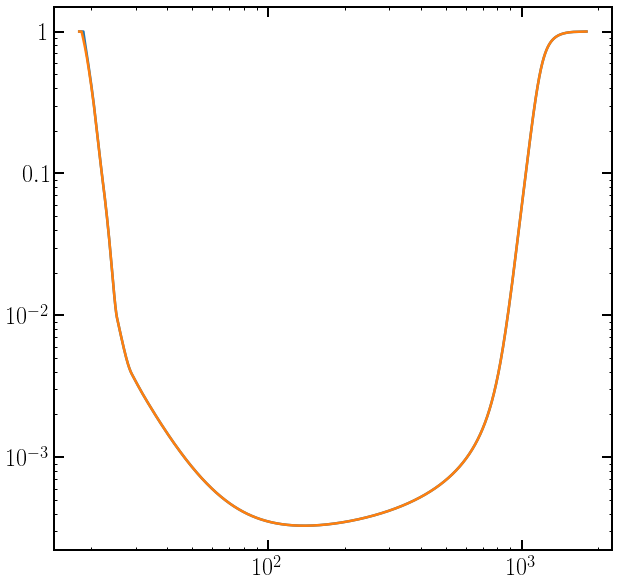

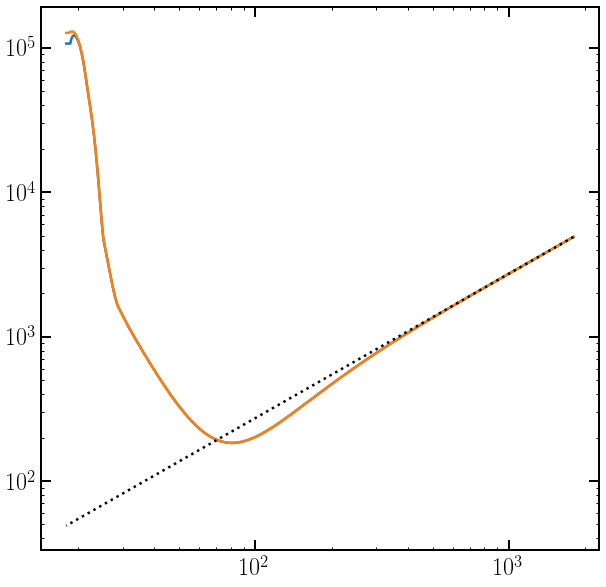

In [35]:
plt.figure()
plt.plot(a[3].rs, a[0])
plt.plot(b[3].rs, b[0])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


plt.figure()
plt.plot(a[3].rs, a[1]/phys.kB)
plt.plot(b[3].rs, b[1]/phys.kB)
plt.plot(a[3].rs, phys.TCMB(a[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


In [15]:
a[0]
a[3].rs[1:]

array([1294.81038615, 1292.22335327, 1289.64148929, ...,   50.10493686,
         50.00482713,   49.90491742])

In [16]:
a = 2
str(a)

'2'